# Goal
The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the ```flow_from_dataframe``` to deal with messier datasets

In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [36]:
all_xray_df = pd.read_csv('../input/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
41263,00010688_002.png,No Finding,2,10688,35,M,AP,2500,2048,0.168,0.168,NaN,../input/images_005/images/00010688_002.png
15660,00004118_000.png,No Finding,0,4118,23,M,AP,2500,2048,0.171,0.171,NaN,../input/images_003/images/00004118_000.png
36209,00009562_003.png,Atelectasis,3,9562,36,F,PA,2992,2991,0.143,0.143,NaN,../input/images_005/images/00009562_003.png


# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

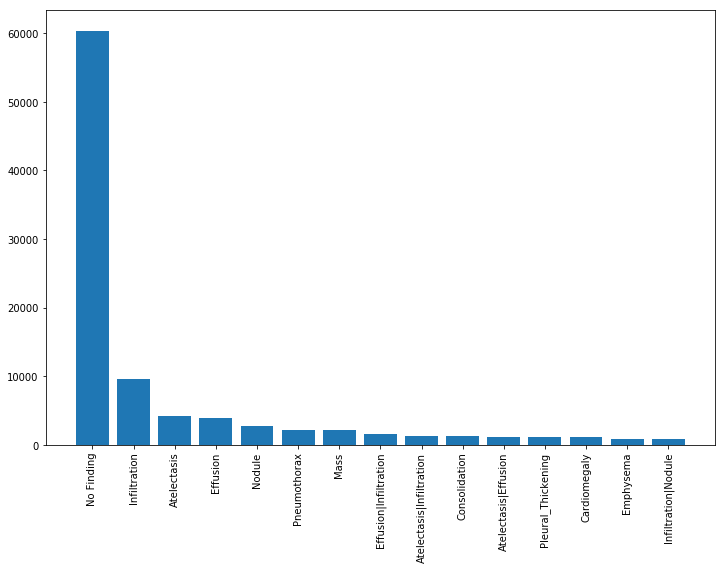

In [37]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [38]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
25044,00006598_001.png,Nodule,1,6598,35,M,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
62011,00015344_001.png,,1,15344,61,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34463,00009069_000.png,Infiltration|Nodule,0,9069,24,F,PA,2790,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [39]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


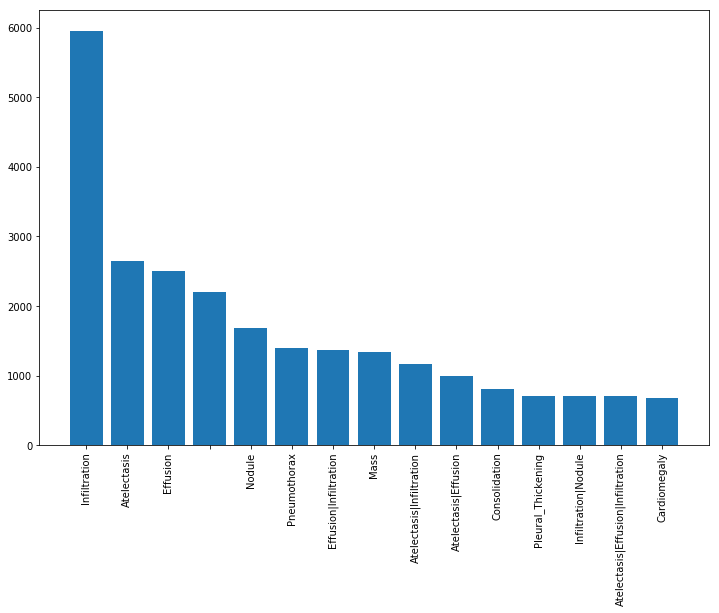

In [40]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

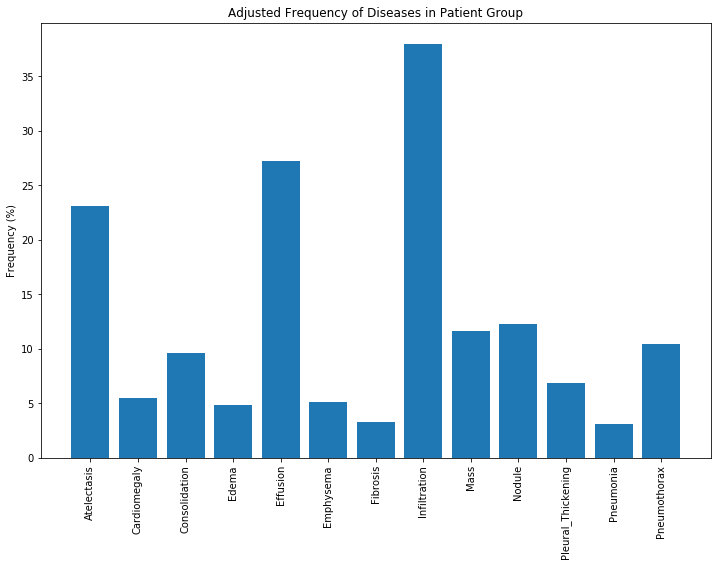

In [41]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [42]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [43]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [44]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [45]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [46]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 30000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images


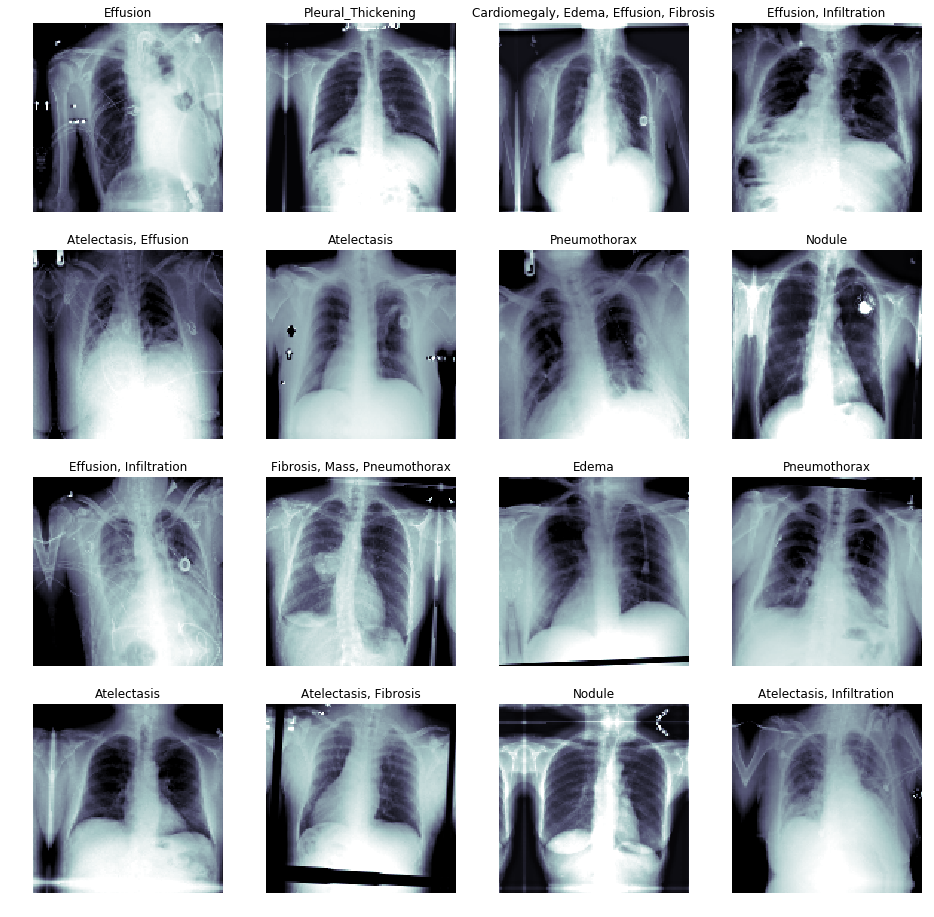

In [47]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Create a simple model
Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features

In [109]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras import regularizers, initializers, optimizers
from keras.optimizers import SGD

model = Sequential()

model.add(Conv2D(filters=16, 
                 kernel_size=7,
                 padding='same', 
                 activation='relu', 
                 input_shape= test_X.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, 
                 kernel_size=5,
                 padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, 
                 kernel_size=5,
                 padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation ='relu')) # Hidden Layers 500 neurons
model.add(Dense(len(all_labels), activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
model.summary()

NameError: name 'multi_disease_model' is not defined

In [103]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

# First Round
Here we do a first round of training to get a few initial low hanging fruit results

In [104]:
model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

Epoch 1/1
100/100 [==============================] - 62s 616ms/step - loss: 3.7674 - acc: 0.1906 - val_loss: 3.6719 - val_acc: 0.2324

Epoch 00001: val_loss improved from inf to 3.67190, saving model to xray_class_weights.best.hdf5


# Check Output
Here we see how many positive examples we have of each category

In [105]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 23.34%
Cardiomegaly: 5.47%
Consolidation: 8.79%
Edema: 4.10%
Effusion: 25.49%
Emphysema: 5.18%
Fibrosis: 3.32%
Infiltration: 38.38%
Mass: 10.25%
Nodule: 12.01%
Pleural_Thickening: 6.15%
Pneumonia: 2.93%
Pneumothorax: 9.67%


In [106]:
pred_Y = model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 1s 1ms/step


# ROC Curves
While a very oversimplified metric, we can show the ROC curve for each metric

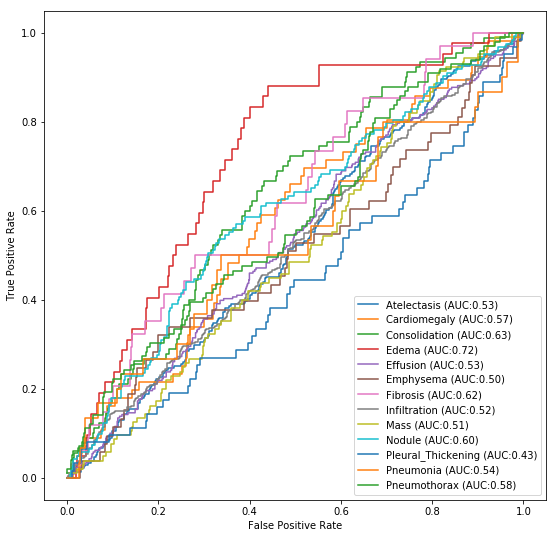

In [107]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

# Continued Training
Now we do a much longer training process to see how the results improve

In [108]:
model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 5 , 
                                  callbacks = callbacks_list)

Epoch 1/5
100/100 [==============================] - 60s 599ms/step - loss: 3.6645 - acc: 0.2097 - val_loss: 3.6106 - val_acc: 0.2119

Epoch 00001: val_loss improved from 3.67190 to 3.61057, saving model to xray_class_weights.best.hdf5
Epoch 2/5
100/100 [==============================] - 61s 611ms/step - loss: 3.7187 - acc: 0.1975 - val_loss: 3.5812 - val_acc: 0.2148

Epoch 00002: val_loss improved from 3.61057 to 3.58116, saving model to xray_class_weights.best.hdf5
Epoch 3/5
100/100 [==============================] - 63s 630ms/step - loss: 3.6710 - acc: 0.1850 - val_loss: 3.6114 - val_acc: 0.2314

Epoch 00003: val_loss did not improve
Epoch 4/5
 38/100 [==========>...................] - ETA: 39s - loss: 3.7157 - acc: 0.2064

KeyboardInterrupt: 

In [ ]:
# load the best weights
model.load_weights(weight_path)

In [ ]:
pred_Y = model.predict(test_X, batch_size = 32, verbose = True)

In [100]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 23.34%, PDx: 66.33%
Cardiomegaly: Dx: 5.47%, PDx: 24.09%
Consolidation: Dx: 8.79%, PDx: 49.75%
Edema: Dx: 4.10%, PDx: 28.57%
Effusion: Dx: 25.49%, PDx: 67.01%
Emphysema: Dx: 5.18%, PDx: 30.74%
Fibrosis: Dx: 3.32%, PDx: 20.63%
Infiltration: Dx: 38.38%, PDx: 87.23%
Mass: Dx: 10.25%, PDx: 42.23%
Nodule: Dx: 12.01%, PDx: 35.33%
Pleural_Thickening: Dx: 6.15%, PDx: 37.10%
Pneumonia: Dx: 2.93%, PDx: 31.69%
Pneumothorax: Dx: 9.67%, PDx: 38.46%


In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

# Show a few images and associated predictions

In [ ]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')